In [125]:
import pandas as pd
import numpy as np

from tqdm import tqdm
from itertools import combinations
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn import metrics, preprocessing

from news_vec.corpus import Corpus

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

mpl.style.use('seaborn-muted')
sns.set(style="whitegrid")

%matplotlib inline

In [3]:
corpus = Corpus('../data/clf-headlines.json/')

2018-12-28 19:27:45,479 | INFO : Reading headlines.
1225511it [00:16, 74962.77it/s] 


In [175]:
def pred_ab(d1, d2):
    
    df = corpus.sample_ab(d1, d2)

    tv = TfidfVectorizer(
        analyzer='word',
        tokenizer=lambda x: x,
        preprocessor=lambda x: x,
        token_pattern=None,
        ngram_range=(1,3)
    )

    df_train, df_test = train_test_split(df)

    X_train = tv.fit_transform(df_train.clf_tokens)
    X_test = tv.transform(df_test.clf_tokens)

    clf = LinearSVC()
    fit = clf.fit(X_train, df_train.domain)

    df_test = df_test.copy()
    df_test['pred'] = fit.decision_function(X_test)
    df_test['pred_true'] = df_test[['domain', 'pred']].apply(lambda x: x[1] if x[0]==fit.classes_[1] else -x[1], 1)
    
    return df_test

In [211]:
def pt_imp_corr(pred_df, domain, max_imp_rank=1):
    
    df = pred_df[pred_df.domain==domain].copy()
    df['imp_rank'] = df.impressions.rank(pct=True)
    df = df[df.imp_rank < max_imp_rank]

    df['log_imp'] = np.log(df.impressions)
    df['pt_scaled'] = preprocessing.scale(df.pred_true)
    
    corr, p = stats.pearsonr(-df.pt_scaled, df.log_imp)

    return corr, p, df

In [258]:
pred_df = pred_ab('huffingtonpost.com', 'dailykos.com')

In [259]:
corr, p, ddf = pt_imp_corr(pred_df, 'huffingtonpost.com')

In [260]:
corr, p

(0.14004492071336716, 1.6640257981050945e-30)

<Figure size 720x360 with 0 Axes>

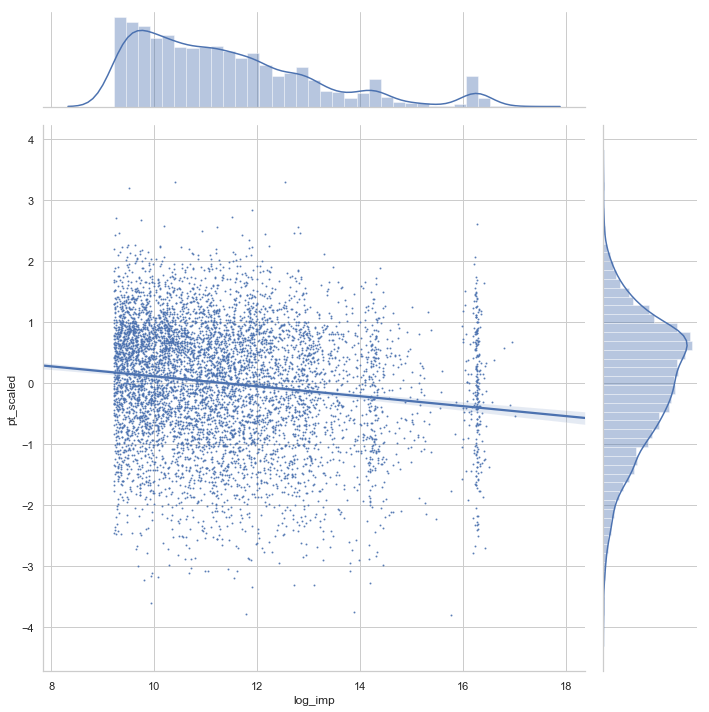

In [261]:
plt.figure(figsize=(10,5))
sns.jointplot(x='log_imp', y='pt_scaled', data=ddf, height=10, kind='reg', scatter_kws=dict(s=1))

In [244]:
pred_df = pred_ab('dailycaller.com', 'buzzfeed.com')

In [251]:
corr, p, ddf = pt_imp_corr(pred_df, 'buzzfeed.com', 0.9)

In [252]:
corr, p

(0.16840321526213659, 6.465896851627075e-40)

<Figure size 720x360 with 0 Axes>

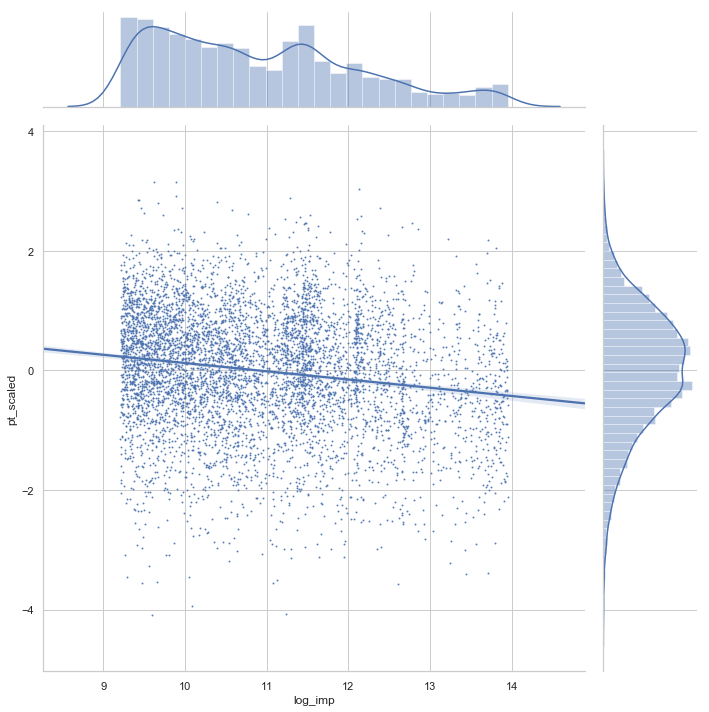

In [253]:
plt.figure(figsize=(10,5))
sns.jointplot(x='log_imp', y='pt_scaled', data=ddf, height=10, kind='reg', scatter_kws=dict(s=1))

In [254]:
pred_df = pred_ab('breitbart.com', 'sputniknews.com')

In [256]:
corr, p, ddf = pt_imp_corr(pred_df, 'breitbart.com', 1)
corr, p

(-0.09252200058435411, 3.079968199910167e-14)

<Figure size 720x360 with 0 Axes>

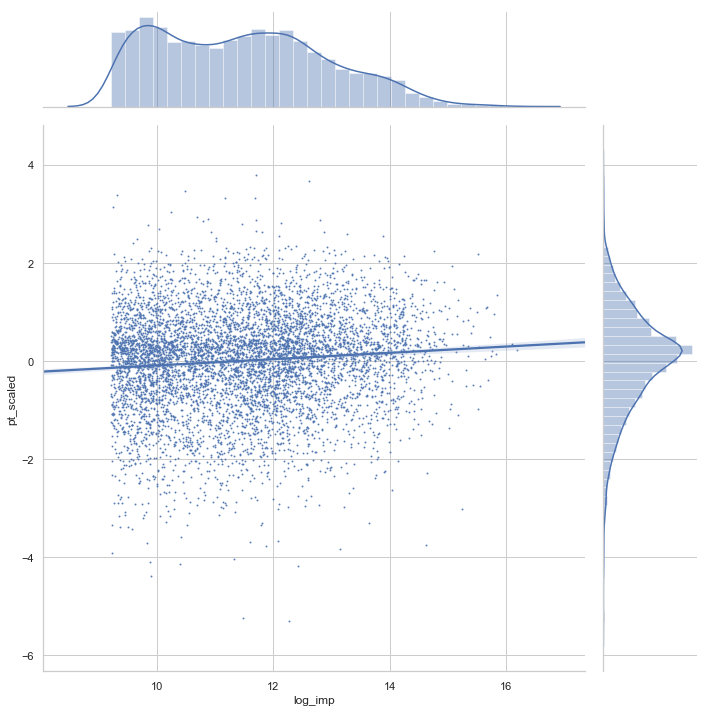

In [257]:
plt.figure(figsize=(10,5))
sns.jointplot(x='log_imp', y='pt_scaled', data=ddf, height=10, kind='reg', scatter_kws=dict(s=1))

In [221]:
domains = corpus.df.domain.unique()

In [222]:
pairs = list(combinations(domains, 2))

In [223]:
rows = []
for d1, d2 in tqdm(pairs):
    pred_df = pred_ab(d1, d2)
    corr1, p1, _ = pt_imp_corr(pred_df, d1)
    corr2, p2, _ = pt_imp_corr(pred_df, d2)
    rows.append((d1, d2, corr1, p1))
    rows.append((d2, d1, corr2, p2))

100%|██████████| 120/120 [20:54<00:00, 10.96s/it]


In [224]:
df = pd.DataFrame(rows, columns=('d1', 'd2', 'corr', 'p'))

In [225]:
df['label'] = df.apply(lambda r: f'{r.d1} -> {r.d2}', 1)

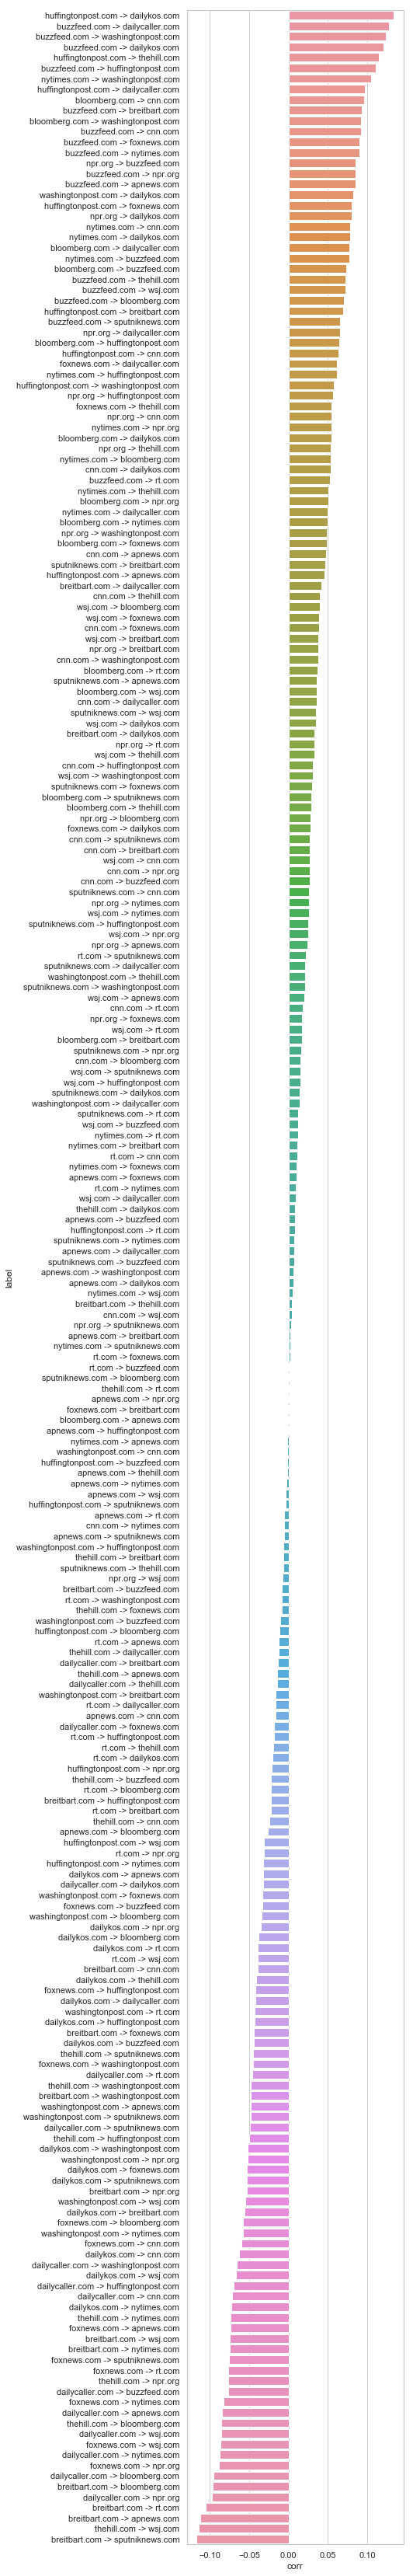

In [226]:
plt.figure(figsize=(5,60))
sns.barplot(x='corr', y='label', data=df.sort_values('corr', ascending=False))

In [275]:
df.groupby('d1').mean().sort_values('corr', ascending=False)

,corr,p
d1,,
buzzfeed.com,0.090053,0.000001
bloomberg.com,0.050214,0.076992
nytimes.com,0.043273,0.233123
npr.org,0.040474,0.105951
huffingtonpost.com,0.037936,0.172564
cnn.com,0.028366,0.121488
wsj.com,0.025386,0.107502
sputniknews.com,0.019609,0.237853
apnews.com,-0.001528,0.625895


In [282]:
df.groupby('d1').corr.max().sort_values(ascending=False)

d1
huffingtonpost.com    0.133605
buzzfeed.com          0.127781
nytimes.com           0.105081
bloomberg.com         0.096372
npr.org               0.085226
washingtonpost.com    0.082263
foxnews.com           0.061221
cnn.com               0.053793
sputniknews.com       0.046507
breitbart.com         0.041980
wsj.com               0.039641
rt.com                0.022487
apnews.com            0.009852
thehill.com           0.008577
dailycaller.com      -0.013112
dailykos.com         -0.032115
Name: corr, dtype: float64

In [284]:
df.groupby('d1').corr.min().sort_values(ascending=True)

d1
breitbart.com        -0.116706
thehill.com          -0.114011
dailycaller.com      -0.097699
foxnews.com          -0.088853
dailykos.com         -0.073059
washingtonpost.com   -0.058285
rt.com               -0.039115
huffingtonpost.com   -0.032019
apnews.com           -0.026101
npr.org              -0.007213
sputniknews.com      -0.006727
cnn.com              -0.005786
nytimes.com          -0.001379
bloomberg.com        -0.000834
wsj.com               0.008761
buzzfeed.com          0.052196
Name: corr, dtype: float64